Dataset already exists.


<ipython-input-9-11e58578e041>:104: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3547 - loss: 2.7434

13/13 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.3683 - loss: 2.7036 - val_accuracy: 0.4666 - val_loss: 2.8939
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8087 - loss: 1.0223

13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8093 - loss: 1.0152 - val_accuracy: 0.6425 - val_loss: 2.1692
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8636 - loss: 0.6084

13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8650 - loss: 0.6039 - val_accuracy: 0.7335 - val_loss: 1.5980
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9240 - loss: 0.3460

13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9237 - loss: 0.3450 - val_accuracy: 0.7428 - val_loss: 1.4708
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9456 - loss: 0.2150

13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9457 - loss: 0.2150 - val_accuracy: 0.7727 - val_loss: 1.1613
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


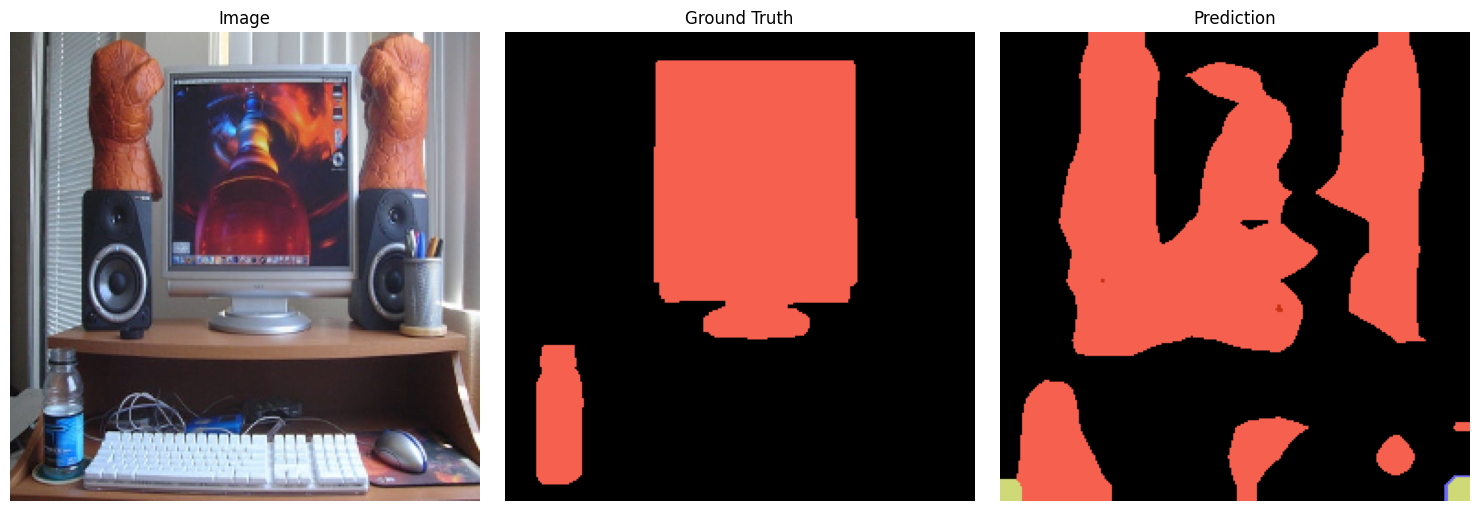

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import cv2
import requests
import tarfile
from tqdm import tqdm

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 21
EPOCHS = 5
COLORMAP = np.random.randint(0, 255, (NUM_CLASSES, 3))
COLORMAP[0] = [0, 0, 0]  # Background

class VOCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, voc_dir, split="train", batch_size=BATCH_SIZE, max_samples=None, shuffle=True):
        self.split_file = os.path.join(voc_dir, "ImageSets", "Segmentation", f"{split}.txt")
        self.image_dir = os.path.join(voc_dir, "JPEGImages")
        self.mask_dir = os.path.join(voc_dir, "SegmentationClass")

        with open(self.split_file, 'r') as f:
            self.image_ids = [line.strip() for line in f.readlines()]

        if max_samples and max_samples < len(self.image_ids):
            self.image_ids = self.image_ids[:max_samples]

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.image_ids[i] for i in batch_indexes]
        X, y = self._generate_batch(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_batch(self, batch_ids):
        X = np.zeros((len(batch_ids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        y = np.zeros((len(batch_ids), IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES), dtype=np.float32)

        for i, img_id in enumerate(batch_ids):
            try:
                img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask_path = os.path.join(self.mask_dir, f"{img_id}.png")
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img, mask = self._preprocess_data(img, mask)
                X[i] = img
                y[i] = mask
            except Exception as e:
                print(f"Error: {e}")
                y[i, :, :, 0] = 1  # fallback to background
        return X, y

    def _preprocess_data(self, image, mask):
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)).astype(np.float32) / 255.0
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = np.clip(mask, 0, NUM_CLASSES - 1)

        mask_one_hot = np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES), dtype=np.float32)
        for i in range(NUM_CLASSES):
            mask_one_hot[:, :, i] = (mask == i)

        return image, mask_one_hot

def download_extract_pascal_voc(data_dir="pascal_voc_data"):
    os.makedirs(data_dir, exist_ok=True)
    url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
    download_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar")
    voc_dir = os.path.join(data_dir, "VOCdevkit", "VOC2012")

    if os.path.exists(voc_dir):
        print("Dataset already exists.")
        return voc_dir

    if not os.path.exists(download_path):
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))
        with open(download_path, "wb") as file, tqdm(total=total_size, unit="B", unit_scale=True, desc="Downloading") as bar:
            for data in response.iter_content(8192):
                file.write(data)
                bar.update(len(data))

    with tarfile.open(download_path) as tar:
        tar.extractall(path=data_dir)
    return voc_dir

def build_lightweight_deeplabv3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.get_layer('block_13_expand_relu').output

    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, x.shape[-1]))(pool)
    pool = layers.Conv2D(128, 1, use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation('relu')(pool)
    pool = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(pool)

    conv1x1 = layers.Conv2D(128, 1, use_bias=False)(x)
    conv1x1 = layers.BatchNormalization()(conv1x1)
    conv1x1 = layers.Activation('relu')(conv1x1)

    conv3x3_1 = layers.Conv2D(128, 3, padding='same', dilation_rate=6, use_bias=False)(x)
    conv3x3_1 = layers.BatchNormalization()(conv3x3_1)
    conv3x3_1 = layers.Activation('relu')(conv3x3_1)

    conv3x3_2 = layers.Conv2D(128, 3, padding='same', dilation_rate=12, use_bias=False)(x)
    conv3x3_2 = layers.BatchNormalization()(conv3x3_2)
    conv3x3_2 = layers.Activation('relu')(conv3x3_2)

    concat = layers.Concatenate()([pool, conv1x1, conv3x3_1, conv3x3_2])
    x = layers.Conv2D(128, 1, use_bias=False)(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(x)
    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(x)

    return tf.keras.Model(inputs=base_model.input, outputs=outputs)

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(NUM_CLASSES):
        colored_mask[pred_mask == i] = COLORMAP[i]
    return colored_mask

def display_sample(image, mask, prediction=None):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    gt = np.argmax(mask, axis=-1)
    gt_color = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
    for i in range(NUM_CLASSES):
        gt_color[gt == i] = COLORMAP[i]
    plt.imshow(gt_color)
    plt.axis('off')

    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(create_mask(prediction))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # GPU memory handling
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    voc_dir = download_extract_pascal_voc()
    if voc_dir is None:
        return

    train_gen = VOCDataGenerator(voc_dir, split="train", batch_size=BATCH_SIZE, max_samples=50)
    val_gen = VOCDataGenerator(voc_dir, split="val", batch_size=BATCH_SIZE, max_samples=20)

    model = build_lightweight_deeplabv3()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint("lite_deeplabv3.h5", save_best_only=True, monitor='val_loss')
    early_stop = EarlyStopping(patience=3, monitor='val_loss')

    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[checkpoint, early_stop])

    # Test visualize
    x_sample, y_sample = val_gen[0]
    pred = model.predict(np.expand_dims(x_sample[0], axis=0))[0]
    display_sample(x_sample[0], y_sample[0], pred)

if __name__ == "__main__":
  main()